# Train And Test - Classification XPU

## Classification

- Imports
  - standard libs
  - 3rd party libs
  - alpabetical or logical grouping
- Set random seed
- Config and Hyperparams
- Dataset and Dataloader
- Model definition/class
- Helper functions (training, eval, visualization)
- Then main code

Note: You can flip torch.amp on and off to test, this is work on XPU. Note this is not a great example case for leveraging amp but it is functional for testing. This is a setting with the hyperparameters.

2025-01-17 21:13:22,743 - root - INFO - Seed set to: 405878332
2025-01-17 21:13:22,744 - root - INFO - Using device: xpu
2025-01-17 21:13:22,752 - root - INFO - X_train shape: torch.Size([4000, 2])
2025-01-17 21:13:22,753 - root - INFO - X_test shape: torch.Size([1000, 2])
2025-01-17 21:13:22,753 - root - INFO - y_train shape: torch.Size([4000])
2025-01-17 21:13:22,754 - root - INFO - y_test shape: torch.Size([1000])


File exists, skipping download


NameError: name 'device' is not defined

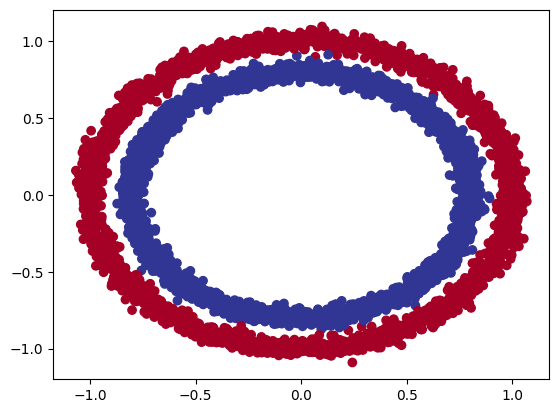

In [17]:
import logging
from pathlib import Path
import random
import requests

import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set or adjust your hyperparameters and amp/cpu override
hp = {
    "n_samples": 5000,
    "test_size": 0.2,
    "learning_rate": 0.02,
    "noise": 0.03,
    "epochs": 1500,
    "input_features": 2,
    "output_features": 1,
    "hidden_units": 24,
    "random_seed": 42,
    "randomize_seed": True,
    "cpu_only": False,
}
# Logging configuration
logging.basicConfig(level=logging.DEBUG, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# Randomize seed if set to True
if hp['randomize_seed']:
    hp['random_seed'] = random.randint(0, 1000000000)
logging.info(f"Seed set to: {hp['random_seed']}")   

def get_device():
    """
    This will check for an Intel XPU device and return it if available, otherwise it will return cpu.

    Returns the torch device to use.
    """
    if hp['cpu_only'] == False:
        #device = "xpu" if torch.xpu.is_available() else "cpu"
        if torch.xpu.is_available():
            device = "xpu"
        elif torch.cuda.is_available():
            device = "cuda"
        else:
            device = "cpu"

        logging.info(f"Using device: {device}")
        return device
    else:
        logging.info("Using CPU only")
        return "cpu"

# Basic Classification Model with ReLU activations
class ClassificationModel(nn.Module):
    def __init__(self, input_features = 2, output_features = 1, hidden_units = 8):

        super().__init__()

        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features),
        )
    def forward(self, x):

        return self.linear_layer_stack(x)

def generate_data(samples, noise, seed, size):
    """
    This function generates a dataset using sklearn's make_circles function.

    samples: int, number of samples to generate
    noise: float, standard deviation of Gaussian noise added to the data
    seed: int, random seed for reproducibility
    size: float, size of the test set

    Returns the train and test sets as tensors.
    """

    # Generate the dataset
    X, y = make_circles(samples, noise=noise, random_state=seed)

    # Plot the data
    plt.scatter(x = X[:, 0], y = X[:, 1], c = y, cmap = plt.cm.RdYlBu)

    # Turn data into tensors
    X = torch.from_numpy(X).type(torch.float)
    y = torch.from_numpy(y).type(torch.float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=seed)

    return X_train, X_test, y_train, y_test

# Calculate accuracy out of 100 examples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def import_helper_func():
    if Path("helper_functions.py").is_file():
        print("File exists, skipping download")
    else:
        print("Downloading")
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        with open("helper_functions.py", "wb") as f:
            f.write(request.content)

    from helper_functions import plot_predictions, plot_decision_boundary

def set_seed(seed=hp['random_seed']):
    """
    Set seed for reproducibility.
    """
    torch.manual_seed(seed)
    if device == "xpu":
        torch.xpu.manual_seed(seed)
    elif device == "cuda":
        torch.cuda.manual_seed(seed)
    logging.info(f"Seed has been set: {seed}")

def move_to_device(X_train, y_train, X_test, y_test, device="cpu"):
    """
    Moves data to the target device.
    """
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    logging.info(f"X_train device: {X_train.device}, y_train device: {y_train.device}")
    logging.info(f"X_test device: {X_test.device}, y_test device: {y_test.device}")
    return X_train, y_train, X_test, y_test

def train_test_model(model, X_train, y_train, X_test, y_test, loss_fn, optimizer, epochs, device="cpu"):
    """
    Train and test a PyTorch model.

    Args:
        model (torch.nn.Module): A PyTorch model.
        X_train (torch.Tensor): Training data (features).
        y_train (torch.Tensor): Training labels.
        X_test (torch.Tensor): Testing data (features).
        y_test (torch.Tensor): Testing labels.
        loss_fn (torch.nn.Module): An instance of a PyTorch loss function.
        optimizer (torch.optim.Optimizer): An instance of a PyTorch optimizer.
        epochs (int): Number of epochs to train the model for.
        device (str): The target device to run the model on.

    Returns:
        tuple: Training loss, testing loss
    """
    for epoch in tqdm(range(epochs), desc="Training"):
        model.train()

        if device != "cpu":
            with torch.amp.autocast(device):

                y_logits = model(X_train).squeeze()
                y_pred = torch.round(torch.sigmoid(y_logits))
                loss = loss_fn(y_logits, y_train)
                acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
                optimizer.zero_grad()
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
        else:
            y_logits = model(X_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))
            loss = loss_fn(y_logits, y_train)
            acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()

        with torch.inference_mode():

            if device != "cpu":
                with torch.amp.autocast(device):
                    test_logits = model(X_test).squeeze()
                    test_pred = torch.round(torch.sigmoid(test_logits))

            else:
                test_logits = model(X_test).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

        logging.info(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")

def plot_decision_boundary(model, X_train, y_train, X_test, y_test):
    # Plot decision boundary of the model
    plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, X_train, y_train)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, X_test, y_test)






























# Main function to run training, testing, saving of the model
def main():

    # Set the device
    device = get_device()

    # Download helper functions
    import_helper_func()

    # Call the function to generate the data
    X_train, X_test, y_train, y_test = generate_data(samples=hp['n_samples'], noise=hp['noise'], seed=hp['random_seed'], size=hp['test_size'])

    # Check the shapes of the data, DELETE THIS WHEN DONE SETTING UP
    # Check the shapes of the data, DELETE THIS WHEN DONE SETTING UP
    # Check the shapes of the data, DELETE THIS WHEN DONE SETTING UP
    logging.info(f"X_train shape: {X_train.shape}")
    logging.info(f"X_test shape: {X_test.shape}")
    logging.info(f"y_train shape: {y_train.shape}")
    logging.info(f"y_test shape: {y_test.shape}")

    # Set with hyperparameters    
    model_0 = ClassificationModel(input_features=hp['input_features'], output_features=hp['output_features'], hidden_units=hp['hidden_units']).to(device)

    # Make predictions
    with torch.inference_mode():
        untrained_preds = model_0(X_test.to(device)) # pass test data to model/device

    loss_fn = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.SGD(params=model_0.parameters(), lr=hp['learning_rate'])

    # View first 5 outputs of the forweard pass on the test data
    model_0.eval() # Use training mode when making predictions
    with torch.inference_mode(): # Use inference mode when making predictions
        y_logits = model_0(X_test.to(device))[:5]

    y_pred_probs = torch.sigmoid(y_logits)

    ##### Find the predicted labels
    # We got raw logits, then turned them into pred probs, now we need pred labels
    y_preds = torch.round(y_pred_probs) # predicted labels

    # In Full (logits -> pred probs -> pred labels)
    y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

    # Get rid of extra dimension
    y_preds.squeeze()

    set_seed(hp['random_seed'])

    X_train, y_train, X_test, y_test = move_to_device(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, device=device)

    if hp['cpu_only'] == False:
        scaler = torch.amp.GradScaler(device)

    train_test_model(model_0, X_train, y_train, X_test, y_test, loss_fn, optimizer, hp['epochs'], device)

    plot_decision_boundary(model_0, X_train, y_train, X_test, y_test)

# Run the main function
if __name__ == '__main__':
    main()

#
#
#
#
#
#
#
#
#


In [1]:
#
#
#
#
#
#
#
#
#


# # Building and eval loop
# for epoch in range(epochs):
#     # Training
#     model_0.train()

    # if use_amp:
    #     # Forward pass with autocast for mixed precision
    #     with torch.amp.autocast(device):
    #         # Forward Pass
    #         # y_logits = model_0(X_train).squeeze() # pass raw logits
    #         # y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    # else:
    #     # Forward Pass
    #     # y_logits = model_0(X_train).squeeze() # pass raw logits
    #     # y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # loss = loss_fn(y_logits, y_train)
    # acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    # optimizer.zero_grad()

    # # Backward pass with GradScaler for mixed precision
    # scaler.scale(loss).backward()
    # scaler.step(optimizer)
    # scaler.update()

    # Testing
    # model_0.eval()
    # with torch.inference_mode():

    #     if use_amp:
    #         # Forward pass with autocast for mixed precision
    #         with torch.amp.autocast(device):
    #             # Testing forward pass
    #             test_logits = model_0(X_test).squeeze()
    #             test_pred = torch.round(torch.sigmoid(test_logits))

    #     else:
    #         # Testing forward pass
    #         test_logits = model_0(X_test).squeeze()
    #         test_pred = torch.round(torch.sigmoid(test_logits))
            
    #     # Testing Calc loss and accuracy
    #     test_loss = loss_fn(test_logits, y_test)
    #     test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    # # Print output
    # if epoch % (epochs / 10) == 0:
    #     print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")



# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)





In [ ]:

#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#
#

# Standard library imports
from pathlib import Path
import requests

# Third-party library imports
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Static seed for reproducibility or turn on randomization
RANDOM_SEED = 42
RANDOMIZE_SEED = False

# Check if we should use a static seed, if not randomize it
if RANDOMIZE_SEED:
    RANDOM_SEED = random.randint(0, 1000000000)
    print(f"Using seed: {RANDOM_SEED}")

# Setup device agnostic code, you can extend to include cuda as well
# device = "xpu" if torch.xpu.is_available() else "cuda" if torch.xpu.is_available else "cpu"
# This will try to use xpu, fallback to cuda, then to cpu, I have this in my mixed gpu environments
device = "xpu" if torch.xpu.is_available() else "cpu"
print(f"Using device: {device}")

# Initialize Hyperparameters
# Make n samples for dataset
n_samples = 5000
test_size = 0.2 # 0.2 = 20% test, 80% train
learning_rate = 0.02
noise = 0.03 # Noise for circles which will make them not perfect circles
epochs = 5000
input_features = 2
output_features = 1
hidden_units = 24
# Set to True to use mixed precision training (automatic mixed precision)
# This will be less accurate when turned on but technically faster
use_amp = True

# Generate the dataset
# Create Circles
X, y = make_circles(n_samples, noise = noise, random_state = RANDOM_SEED)

plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu);

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Scikit learn has methods to do Train/Test split on data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = test_size, 
                                                    random_state = RANDOM_SEED)

# Build model - multi-class
class ClassificationModel(nn.Module):
    def __init__(self, input_features = 2, output_features = 1, hidden_units = 8): # defaults
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units, out_features = output_features),
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

# Calculate accuracy out of 100 examples
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # item gets the value out as a single item, this also moves it to cpu
    acc = (correct / len(y_pred)) * 100
    return acc

# Set with hyperparameters    
model_0 = ClassificationModel(input_features = input_features, output_features = output_features, hidden_units = hidden_units).to(device)

# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device)) # pass test data to model/device

loss_fn = nn.BCEWithLogitsLoss() # Sigmoid activation function built in, this is the numerical stable way

# Optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = learning_rate)

# View first 5 outputs of the forweard pass on the test data
model_0.eval() # Use training mode when making predictions
with torch.inference_mode(): # Use inference mode when making predictions
    y_logits = model_0(X_test.to(device))[:5]

y_pred_probs = torch.sigmoid(y_logits)

##### Find the predicted labels
# We got raw logits, then turned them into pred probs, now we need pred labels
y_preds = torch.round(y_pred_probs) # predicted labels

# In Full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Get rid of extra dimension
y_preds.squeeze()

# Seed
torch.manual_seed(RANDOM_SEED)
torch.xpu.manual_seed(RANDOM_SEED)

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Initialize GradScaler for mixed precision training
scaler = torch.GradScaler(device)

# Building and eval loop
for epoch in range(epochs):
    # Training
    model_0.train()

    if use_amp:
        # Forward pass with autocast for mixed precision
        with torch.amp.autocast(device):
            # Forward Pass
            y_logits = model_0(X_train).squeeze() # pass raw logits
            y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    else:
        # Forward Pass
        y_logits = model_0(X_train).squeeze() # pass raw logits
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
    optimizer.zero_grad()

    # Backward pass with GradScaler for mixed precision
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Testing
    model_0.eval()
    with torch.inference_mode():

        if use_amp:
            # Forward pass with autocast for mixed precision
            with torch.amp.autocast(device):
                # Testing forward pass
                test_logits = model_0(X_test).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))

        else:
            # Testing forward pass
            test_logits = model_0(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
            
        # Testing Calc loss and accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

    # Print output
    if epoch % (epochs / 10) == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}% | Device: {device}")

# Download helper func from learn pytorch repo if its not downlaoded
if Path("helper_functions.py").is_file():
    print("File exists, skipping download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

# Then import the file
from helper_functions import plot_predictions, plot_decision_boundary

# Plot decision boundary of the model
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)



